<h1 style="text-align:center; font-size: 50px; margin: 0; font-weight: 300; margin-bottom: 5px">Exoplanets Homework 3 - Tom Wagg</h1>
<h3 style="text-align:center; font-size: 25px; font-style: italic; font-weight: 100; margin: 0; margin-bottom: 10px">It's TTV Time</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const

import rebound

from scipy.optimize import curve_fit

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Contents
- [Problem 1](#p1)
- [Problem 2](#p2)
- [Problem 3](#p3)
- [Problem 4](#p4)

<h1><a id="p1">Problem 1</a></h1>

*Install the dynamical integrator REBOUND using Python:https://rebound.readthedocs.io/en/latest/. Look through the examplenotebooks, and familiarize yourself with initializing and running a planetary system. [2 pt]*

<hr>

In [3]:
rebound.__version__

'3.19.3'

Okay rebound is installed, let's run a test simulation

In [4]:
sim = rebound.Simulation()

sim.add(m=1.)                # Central object
sim.add(m=1e-3, a=1., e=0.1) # Jupiter mass planet 
sim.add(a=1.4, e=0.1)        # Massless test particle

sim.integrate(100.)

for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.calculate_orbits(): 
    print(o)

0.0001379031111733169 0.11100285684422287 0.0
0.7620968888266642 -0.3934338982350228 0.0
-1.5948501191422428 0.20487096187200812 0.0
<rebound.Orbit instance, a=0.9999999999999998 e=0.10000000000000006 inc=0.0 Omega=0.0 omega=0.0 f=5.698402270529936>
<rebound.Orbit instance, a=1.4174273398342736 e=0.12988282793113465 inc=0.0 Omega=0.0 omega=0.09938842199489617 f=2.9831333920230048>


<h1><a id="p2">Problem 2</a></h1>

*Look up the parameters of the multi-transiting planet system Kepler-289c/d (aka Planethunters 3; ignore planet b). Assume the planets’ orbits lie in a plane, and vary the inclination of the system (so that it would not transit). Pretend that the masses were detected with RV (they were actually measured with TTVs!), so that as you incline the orbit, the planet masses increase as $(sin \iota)^{−1}$. At what inclination does the system become unstable after $10^3$ orbits of the inner planet?*

*What upper limit would this place on the planets’ masses if they were measured with RV rather than TTV?*

<hr>

### Find the minimum inclination

We can find the data for Kepler-289 here: http://www.openexoplanetcatalogue.com/planet/Kepler-289%20c/

In [5]:
kepler289star = {
    "mass": 1.08 * u.Msun,
    "radius": 1.00 * u.Rsun
}

kepler289d = {
    "mass": 0.013 * u.Mjup,
    "radius": 0.239 * u.Rjup,
    "a": 0.33 * u.AU
}

kepler289c = {
    "mass": 0.41 * u.Mjup,
    "radius": 1.034 * u.Rjup,
    "a": 0.51 * u.AU
}

kepler289_system = [kepler289star, kepler289d, kepler289c]

In [6]:
def create_kepler289_sim(inv_sini=1):
    # start simulation, adjust units
    sim = rebound.Simulation()
    sim.units = ("yr", "AU", "Msun")

    sim.add(m=kepler289star["mass"].to(u.Msun).value, r=kepler289star["radius"].to(u.AU).value)
    sim.add(m=kepler289d["mass"].to(u.Msun).value * inv_sini, r=kepler289d["radius"].to(u.AU).value, a=kepler289d["a"].to(u.AU).value)
    sim.add(m=kepler289c["mass"].to(u.Msun).value * inv_sini, r=kepler289c["radius"].to(u.AU).value, a=kepler289c["a"].to(u.AU).value)
    sim.move_to_com()
    
    return sim

In [7]:
def calc_ang_mom(sim):
    ang_mom = 0
    for particle in sim.particles:
        r = np.sqrt(particle.x**2 + particle.y**2 + particle.z**2)
        v = np.sqrt(particle.vx**2 + particle.vy**2 + particle.vz**2)
        ang_mom += particle.m * v * r
    return ang_mom

In [8]:
def assess_stability(final_orbits, original_ang_mom, final_ang_mom, verbose=False):
    # check that orbits did not cross
    if final_orbits[0].a > final_orbits[1].a:
        if verbose:
            print("Orbits crossed!")
        return False
    
    # check that orbits are closed
    for orbit in final_orbits:
        if orbit.a < 0 or orbit.e > 1:
            if verbose:
                print("An orbit is not closed!")
            return False
        
    # check angular momentum has been conserved
    if final_ang_mom / original_ang_mom > 1.1:
        if verbose:
            print("Angular momentum was not conserved!")
        return False
    
    return True

In [9]:
innermost_period = (2 * np.pi * np.sqrt(kepler289d["a"]**3 / (const.G * kepler289star["mass"]))).to(u.yr).value
outer_period = (2 * np.pi * np.sqrt(kepler289c["a"]**3 / (const.G * kepler289star["mass"]))).to(u.yr).value

for inv_sini in np.linspace(91, 91.1, 50):
    sim = create_kepler289_sim(inv_sini)
    original_ang_mom = calc_ang_mom(sim).round(4)

    sim.integrate(1000 * innermost_period)

    final_orbits = sim.calculate_orbits()
    final_ang_mom = calc_ang_mom(sim).round(4)

    if not assess_stability(final_orbits, original_ang_mom, final_ang_mom, verbose=True):
        print("UNSTABLE!", inv_sini)
        break

Orbits crossed!
UNSTABLE! 91.00816326530612


In [10]:
minimum_inc = np.arcsin(1 / inv_sini)

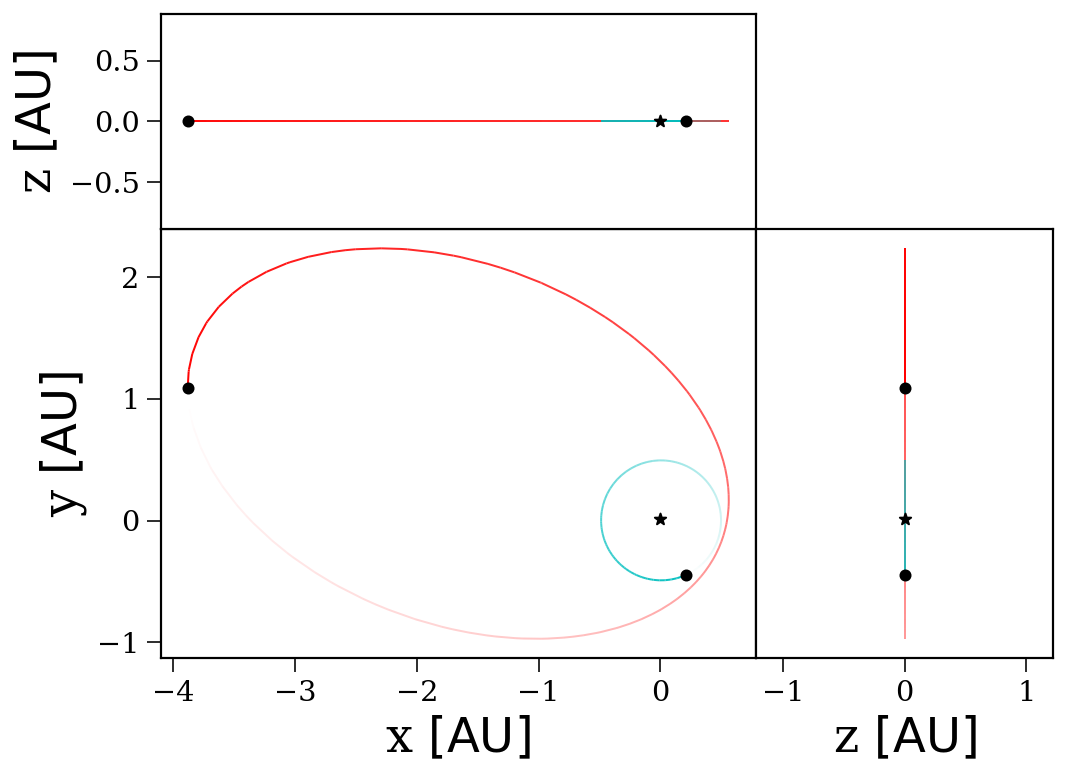

In [11]:
fig, ax, _, _ = rebound.OrbitPlot(sim, unitlabel=r"$[\rm AU]$", color=True, fancy=False, slices=0.5)

### Now let's make some RV "measurements"
First run a sim with Kepler289 and record a bunch of RV measurements

In [12]:
sim = create_kepler289_sim()
original_ang_mom = calc_ang_mom(sim).round(4)

n_steps = 100000
max_time = 1000 * innermost_period
timesteps = np.linspace(0, max_time, n_steps)

rvs = np.zeros(n_steps)
for i, t in enumerate(timesteps):
    sim.integrate(t)
    rvs[i] = sim.particles[0].vx

Next we're going to use scipy to fit sinusoids to this data and remove each planet

In [13]:
def sin_fit(x, P, kstar, c):
    return kstar * np.sin(x * 2 * np.pi / P - c)

In [14]:
kstar_outer = 0.5 * (rvs.max() - rvs.min())
outer_fit = curve_fit(sin_fit, xdata=timesteps, ydata=rvs, p0=[outer_period, kstar_outer, 0])[0]

Now we remove the fitted outer planet and get a fit for the inner planet

In [15]:
remaining_rvs = rvs - sin_fit(timesteps, *outer_fit)
kstar_inner = 0.5 * (remaining_rvs.max() - remaining_rvs.min())
inner_fit = curve_fit(sin_fit, xdata=timesteps, ydata=remaining_rvs, p0=[innermost_period, kstar_inner, 0])[0]

Finally, we can convert these to values of $M_p \sin i$ for each planet.

In [16]:
def get_Mp_sini(kstar, P, Ms=kepler289star["mass"], e=0):
    return (kstar / (2 * np.pi * const.G / (P * (1 - e**2)))**(1/3) * Ms**(2/3)).to(u.Mjup)

In [17]:
P_out_fit, kstar_out_fit, _ = outer_fit
P_in_fit, kstar_in_fit, _ = inner_fit

In [22]:
get_Mp_sini(kstar_out_fit * u.AU / u.yr, P_out_fit * u.yr, kepler289star["mass"]) / np.sin(minimum_inc)

<Quantity 37.30454921 jupiterMass>

In [23]:
get_Mp_sini(kstar_in_fit * u.AU / u.yr, P_in_fit * u.yr, kepler289star["mass"]) / np.sin(minimum_inc)

<Quantity 0.2578473 jupiterMass>

<h1><a id="p3">Problem 3</a></h1>

*Simulate the edge-on radial velocity of the star, and then fit this RV with four Keplerian orbits. How big are the residuals? How does this compare to typical RV errors?*

<hr>

[RV Example in REBOUND](https://rebound.readthedocs.io/en/latest/ipython_examples/RadialVelocity/)

<h1><a id="p4">Problem 4</a></h1>

*Look at [REBOUND TTV example](https://rebound.readthedocs.io/en/latest/ipython_examples/TransitTimingVariations/). Make a plot of the TTVs of Kepler-289c/d over 4 years (assuming edge-on, so that planets do in fact tran-sit). Measure amplitude and period of the sinusoidal variation compo-nent. How does it change if you vary the mass of Kepler-289d downwardand upward by a factor of 2?*

<hr>

In [52]:
sim = create_kepler289_sim()

N=100
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i < N:
    y_old = p[1].y - p[0].y
    t_old = sim.t
    sim.integrate(sim.t + innermost_period / 100) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[1].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t + innermost_period / 1000)       # integrate 0.05 to be past the transit

In [53]:
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes, rcond=-1)[0]

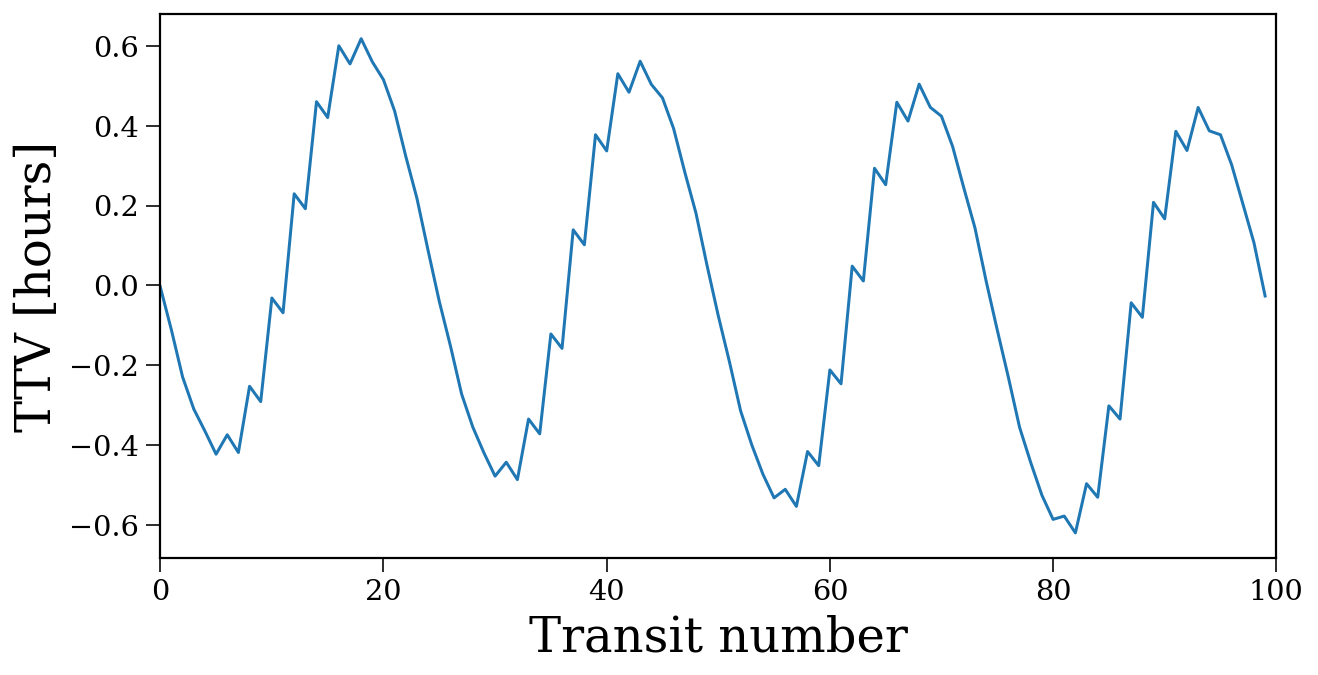

In [55]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.plot(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));